This notebook is a repeat of the 01-example-patient-heart-failure.ipynb

https://github.com/MIT-LCP/mimic-workshop/blob/master/intro_to_mimic/01-example-patient-heart-failure.ipynb

In [1]:
import os
import csv
import time
from io import StringIO

import psycopg
from sqlalchemy import create_engine

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
print(f'DBHOST: {os.environ["DBHOST"]}')
print(f'DBUSER: {os.environ["DBUSER"]}')
print(f'DBPORT: {os.environ["DBPORT"]}')
print(f'DBNAME: {os.environ["DBNAME"]}')


DBHOST: irl.warthog-trout.ts.net
DBUSER: jrizzo
DBPORT: 5432
DBNAME: mimic


In [5]:
URI = f'postgresql+psycopg://{os.environ["DBUSER"]}:{os.environ["DBPASS"]}@{os.environ["DBHOST"]}:{os.environ["DBPORT"]}/{os.environ["DBNAME"]}'
QUERY = '''
    SELECT de.icustay_id
        -- , (strftime('%s',de.charttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS
        , de.charttime
        , ie.intime
        , di.label
        , de.value
        , de.valuenum
        -- , de.uom
    FROM mimiciii.chartevents de
    INNER join mimiciii.d_items di
    ON de.itemid = di.itemid
    INNER join mimiciii.icustays ie
    ON de.icustay_id = ie.icustay_id
    WHERE de.icustay_id = 252522
    ORDER BY charttime;
'''

In [6]:
engine = create_engine(URI)
with engine.connect() as connection:
    # df = pd.read_sql_table(table_name='patients', schema="mimiciii", con=connection)
    # ce = pd.read_sql_query("select * from mimiciii.patients", con=connection)
    ce = pd.read_sql_query(QUERY, con=connection, parse_dates=['charttime', 'intime'])

OperationalError: (psycopg.OperationalError) connection failed: connection to server at "127.0.0.1", port 5432 failed: could not receive data from server: Connection refused
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [5]:
ce["hours"] = (ce["charttime"] - ce["intime"]).dt.total_seconds() / 3600

Did the patient's vital signs breach any alarm thresholds?

Text(0.5, 1.0, 'Heart rate over time from admission to the intensive care unit')

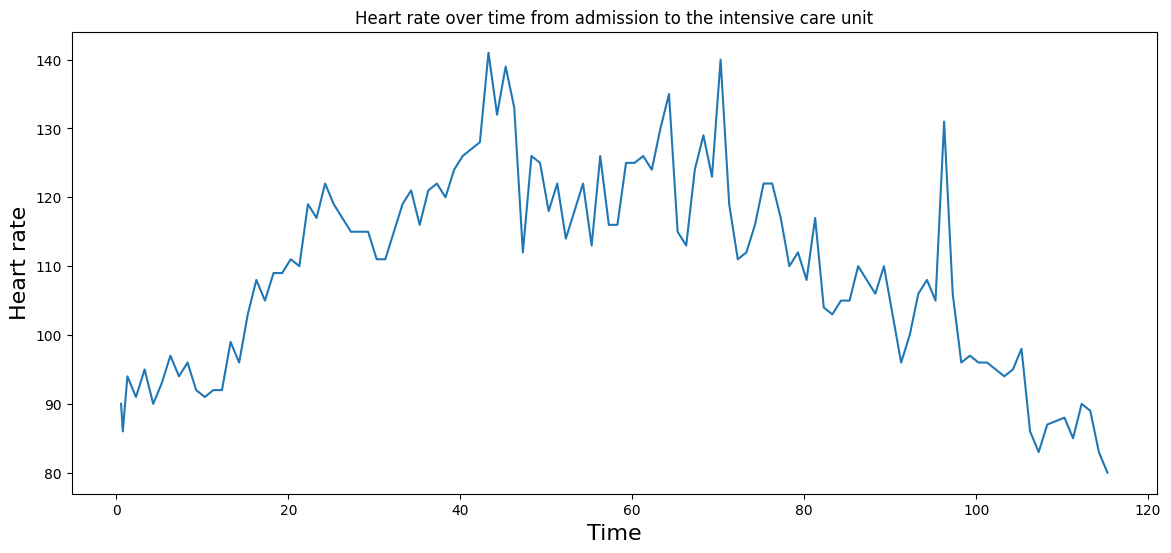

In [6]:
# Set x equal to the times
x_hr = ce.hours[ce.label=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.valuenum[ce.label=='Heart Rate']

# Plot time against heart rate
plt.figure(figsize=(14, 6))
plt.plot(x_hr,y_hr)


plt.xlabel('Time',fontsize=16)
plt.ylabel('Heart rate',fontsize=16)
plt.title('Heart rate over time from admission to the intensive care unit')

(0.0, 55.0)

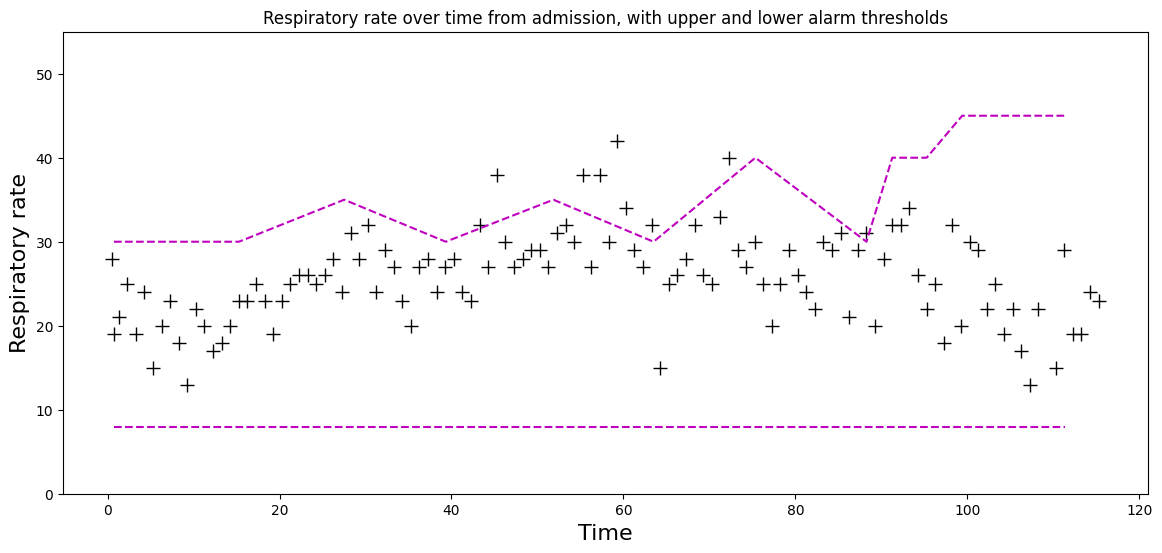

In [7]:
plt.figure(figsize=(14, 6))

plt.plot(ce.hours[ce.label=='Respiratory Rate'], 
         ce.valuenum[ce.label=='Respiratory Rate'],
         'k+', markersize=10, linewidth=4)

plt.plot(ce.hours[ce.label=='Resp Alarm - High'], 
         ce.valuenum[ce.label=='Resp Alarm - High'],
         'm--')

plt.plot(ce.hours[ce.label=='Resp Alarm - Low'], 
         ce.valuenum[ce.label=='Resp Alarm - Low'],
         'm--')

plt.xlabel('Time',fontsize=16)
plt.ylabel('Respiratory rate',fontsize=16)
plt.title('Respiratory rate over time from admission, with upper and lower alarm thresholds')
plt.ylim(0,55)

What is patient's level of consciousness?

In [8]:
# Display the first few rows of the GCS eye response data
ce[ce.label=='GCS - Eye Opening'].head()

,icustay_id,charttime,intime,label,value,valuenum,hours
51,252522,2106-05-31 17:30:00,2106-05-31 16:43:46,GCS - Eye Opening,Spontaneously,4.0,0.770556
211,252522,2106-05-31 20:19:00,2106-05-31 16:43:46,GCS - Eye Opening,Spontaneously,4.0,3.587222
350,252522,2106-06-01 00:24:00,2106-05-31 16:43:46,GCS - Eye Opening,To Speech,3.0,7.670556
541,252522,2106-06-01 04:18:00,2106-05-31 16:43:46,GCS - Eye Opening,To Speech,3.0,11.570556
695,252522,2106-06-01 08:00:00,2106-05-31 16:43:46,GCS - Eye Opening,Spontaneously,4.0,15.270556


(10.0, 165.0)

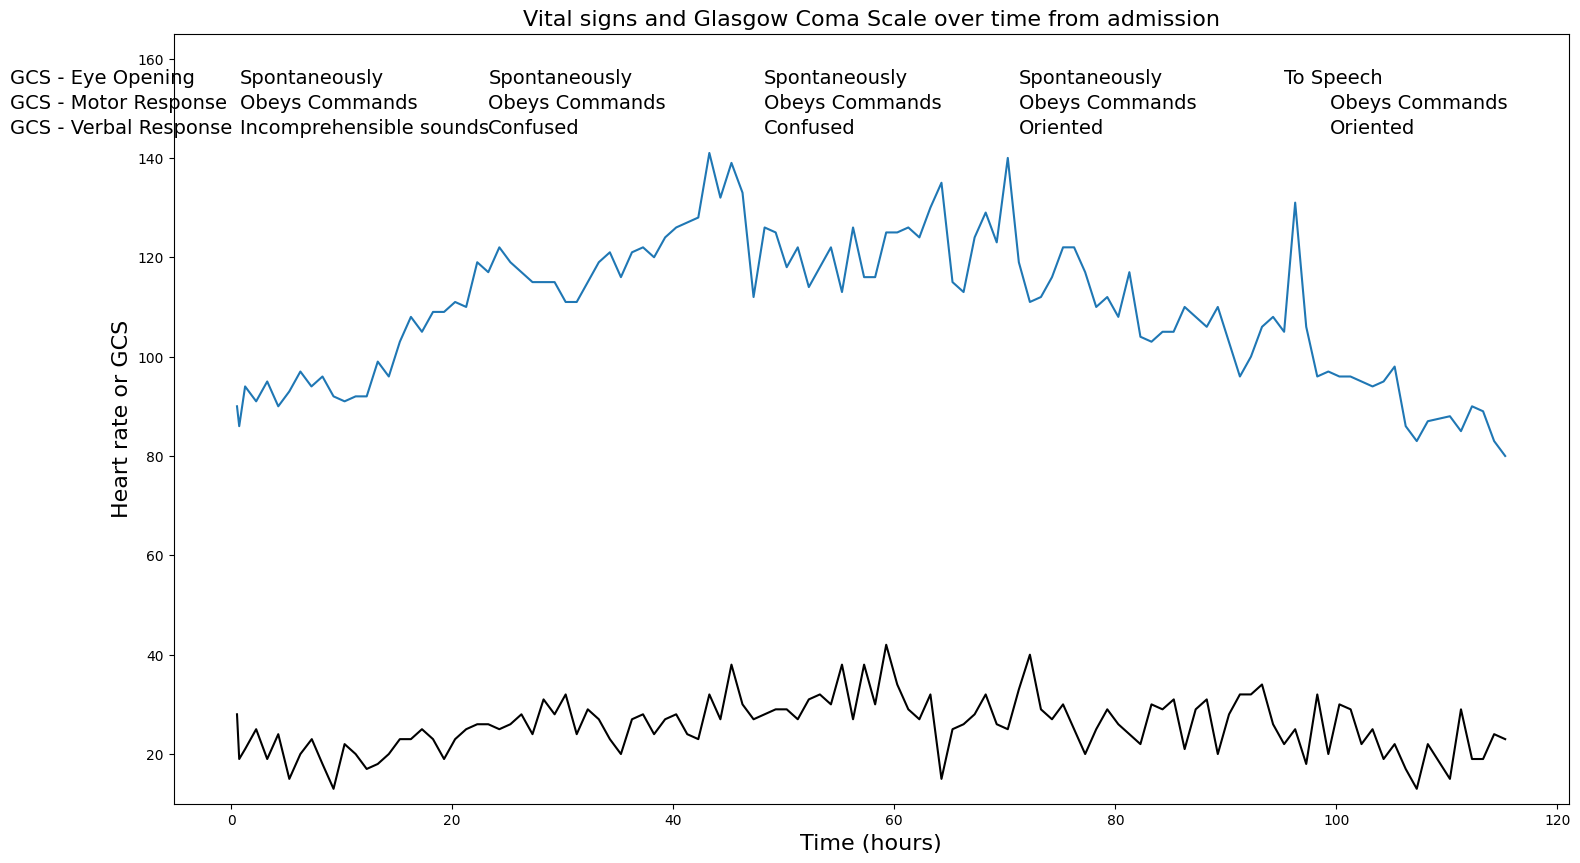

In [9]:
# Prepare the size of the figure
plt.figure(figsize=(18, 10))

# Set x equal to the times
x_hr = ce.hours[ce.label=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.valuenum[ce.label=='Heart Rate']


plt.plot(x_hr,y_hr)

plt.plot(ce.hours[ce.label=='Respiratory Rate'], 
         ce.valuenum[ce.label=='Respiratory Rate'],
         'k', markersize=6)

# Add a text label to the y-axis
plt.text(-20,155,'GCS - Eye Opening',fontsize=14)
plt.text(-20,150,'GCS - Motor Response',fontsize=14)
plt.text(-20,145,'GCS - Verbal Response',fontsize=14)   

# Iterate over list of GCS labels, plotting around 1 in 10 to avoid overlap
for i, txt in enumerate(ce.value[ce.label=='GCS - Eye Opening'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.hours[ce.label=='GCS - Eye Opening'].values[i],155),fontsize=14)
        
for i, txt in enumerate(ce.value[ce.label=='GCS - Motor Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.hours[ce.label=='GCS - Motor Response'].values[i],150),fontsize=14)

for i, txt in enumerate(ce.value[ce.label=='GCS - Verbal Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.hours[ce.label=='GCS - Verbal Response'].values[i],145),fontsize=14)

plt.title('Vital signs and Glasgow Coma Scale over time from admission',fontsize=16)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Heart rate or GCS',fontsize=16)
plt.ylim(10,165)

In [10]:
# load outputs from the patient
query = """
select de.icustay_id
    -- , (strftime('%s',de.charttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS
    , de.charttime
    , ie.intime
    , di.label
    , de.value
    , de.valueuom
from mimiciii.outputevents de 
inner join mimiciii.icustays ie
    on de.icustay_id = ie.icustay_id
inner join mimiciii.d_items di
    on de.itemid = di.itemid
where de.subject_id = 40080
order by charttime;
"""

with engine.connect() as connection:
    oe = pd.read_sql_query(query, connection)

oe["hours"] = (oe["charttime"] - oe["intime"]).dt.total_seconds() / 3600

In [11]:
oe.head()

,icustay_id,charttime,intime,label,value,valueuom,hours
0,252522,2106-05-31 17:29:00,2106-05-31 16:43:46,Pre-Admission,60.0,mL,0.753889
1,252522,2106-05-31 20:18:00,2106-05-31 16:43:46,Foley,80.0,mL,3.570556
2,252522,2106-05-31 21:00:00,2106-05-31 16:43:46,Foley,60.0,mL,4.270556
3,252522,2106-05-31 22:00:00,2106-05-31 16:43:46,Foley,60.0,mL,5.270556
4,252522,2106-05-31 23:00:00,2106-05-31 16:43:46,Foley,60.0,mL,6.270556


<Figure size 1400x1000 with 0 Axes>

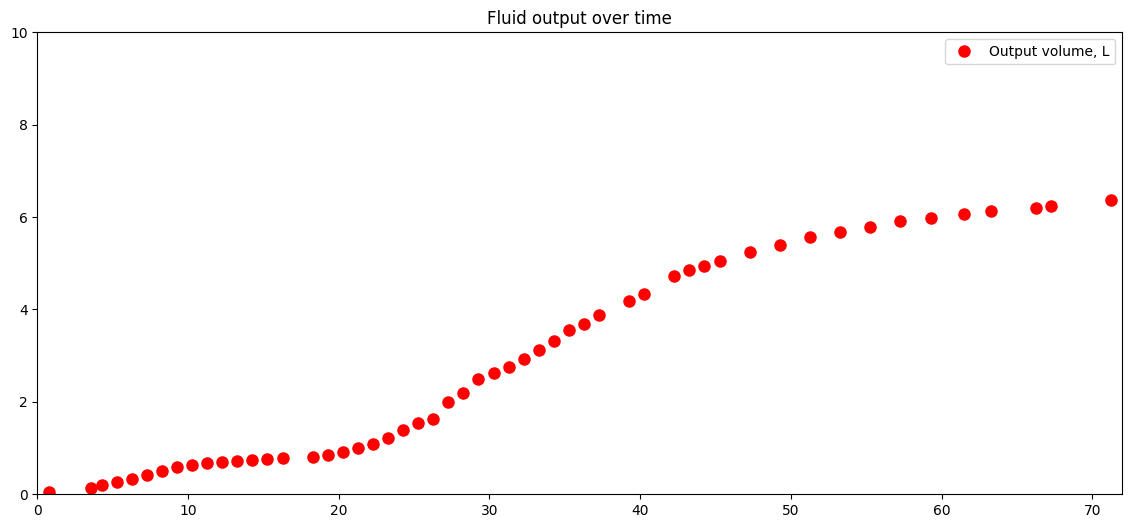

In [12]:
plt.figure(figsize=(14, 10))

plt.figure(figsize=(14, 6))
plt.title('Fluid output over time')

plt.plot(oe.hours, 
         oe.value.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

plt.xlim(0,72)
plt.ylim(0,10)
plt.legend()

In [13]:
query = """
select de.icustay_id
  -- , (strftime('%s',de.starttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS_START
  -- , (strftime('%s',de.endtime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS_END
  , de.starttime
  , ie.intime
  , de.endtime
  , de.linkorderid
  , di.label
  , de.amount
  , de.amountuom
  , de.rate
  , de.rateuom
from mimiciii.inputevents_mv de 
inner join mimiciii.icustays ie
  on de.icustay_id = ie.icustay_id
inner join mimiciii.d_items di
  on de.itemid = di.itemid
where de.subject_id = 40080
order by endtime;
"""

with engine.connect() as connection:
    ie = pd.read_sql_query(query, connection)

ie["hours_start"] = (ie["starttime"] - ie["intime"]).dt.total_seconds() / 3600
ie["hours_end"] = (ie["endtime"] - ie["intime"]).dt.total_seconds() / 3600

In [14]:
ie.head()

,icustay_id,starttime,intime,endtime,linkorderid,label,amount,amountuom,rate,rateuom,hours_start,hours_end
0,252522,2106-05-31 20:00:00,2106-05-31 16:43:46,2106-05-31 20:01:00,279061,Lansoprazole (Prevacid),1.000000,dose,NaN,None,3.270556,3.287222
1,252522,2106-05-31 20:00:00,2106-05-31 16:43:46,2106-05-31 20:01:00,5635057,Gastric Meds,30.000000,ml,NaN,None,3.270556,3.287222
2,252522,2106-05-31 17:29:00,2106-05-31 16:43:46,2106-05-31 21:59:00,4337240,NaCl 0.9%,45.000001,ml,10.0,mL/hour,0.753889,5.253889
3,252522,2106-06-01 00:00:00,2106-05-31 16:43:46,2106-06-01 00:01:00,775255,Free Water,300.000000,ml,NaN,None,7.270556,7.287222
4,252522,2106-05-31 20:30:00,2106-05-31 16:43:46,2106-06-01 02:30:00,8221764,Nutren 2.0 (Full),60.000001,ml,10.0,mL/hour,3.770556,9.770556


In [15]:
ie['label'].unique()

array(['Lansoprazole (Prevacid)', 'Gastric Meds', 'NaCl 0.9%',
       'Free Water', 'Nutren 2.0 (Full)', 'Furosemide (Lasix)',
       'Dextrose 5%', 'Norepinephrine', 'Insulin - Humalog', 'Metoprolol',
       'Metronidazole', 'PO Intake', 'GT Flush', 'Morphine Sulfate'],
      dtype=object)

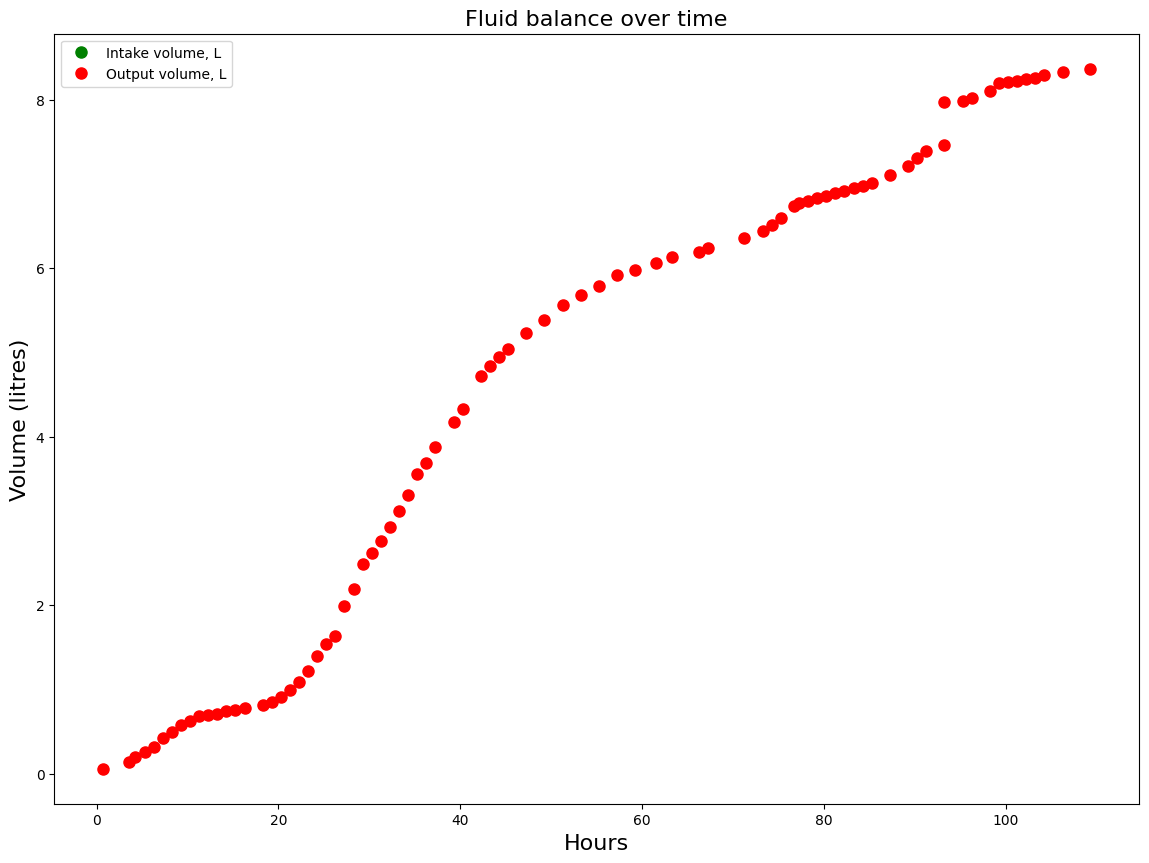

In [16]:
plt.figure(figsize=(14, 10))

# Plot the cumulative input against the cumulative output
plt.plot(ie.hours_end[ie.amountuom=='mL'], 
         ie.amount[ie.amountuom=='mL'].cumsum()/1000, 
         'go', markersize=8, label='Intake volume, L')

plt.plot(oe.hours, 
         oe.value.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

plt.title('Fluid balance over time',fontsize=16)
plt.xlabel('Hours',fontsize=16)
plt.ylabel('Volume (litres)',fontsize=16)
# plt.ylim(0,38)
plt.legend()